# Working with GrIMP Velocity Products Using nisarVel and nisarVelSeries Classes
---

This notebook illustrates some of the capabilities of the `nisarVel` and `nisarVelSeries` classes for working with GrIMP velocity products. There are two classes, each derived from the same parent class so they have similar functionality. The main difference is that a `nisarVel` instance works with a velocity map for a single date. By constrast, the `nisarVelSeries` can incorporate any number of velocity products, so long as they have the same geometry (resolution and extent; e.g., all Greenand NSIDC-0725 velocity maps). For the terraSAR-X velocities, this means a `nisarVelSeries` instance can handle a single glacier box, but multiple `velSeries` instances would be needed to work with multiple glacier boxes. 

In [1]:
from IPython.display import Markdown, display
display(Markdown(open('Features.md', encoding='utf-8').read()))

## Key Features
Several features of these classes are useful for working with the GrIMP data as described below.

### Cloud Optimized Geotiffs
Much of the functionality described here relies on the use of Cloud-optimized Geotiffs ([COGs](https://developers.planet.com/planetschool/an-introduction-to-cloud-optimized-geotiffs-cogs-part-1-overview/)) for GriMP products, which have the following properties:
    
- The header with information about how the data are organized is all located at the beginning of the file. As a result, a result a single read provides all of the information about how the data are organized in the file. In some tiffs this information is distributed throughout the file, requiring many read operations to retrieve all of the metadata.
- The data are tiled (i.e., stored as a series of blocks like a checkerboard) rather than as a line-by-line raster. The tiling facilitates faster access to limited subsets. For example, to read a 50-by-50 km region from a Greeland mosaic, only a few tiles that cover that region need to be downloaded. By contrast, with conventional rastering, a 50km-by-1500km (~width of Greenland mosaics) would have to read (up to 30x more data) and then cropped to the desired width of 50km. 
- A consistent set of overview images (pyramids) are stored with the data, allowing low-resolution images to be quickly extracted to create figures where the full resolution is not required (e.g., for inset figures).


### Built on Xarray
[*Xarray*](https://docs.xarray.dev/en/stable/) is a powerful python tool that bundles metadata with data stored in NumPy arrays. While extremely powerful, it can be cumbersome for novice users. The classes described below are designed so that users can take advantage of the full functionality of Xarray, or bypass it entirely and access the data using either as [numpy](https://numpy.org) arrays or methods that perform tasks commonly applied to the data (interpolation, basic statistics, etc).

### Dask
[Dask](https://dask.org) is a program for applying parallel operations using Xarray, NumPy, and other libraries.  Dask functionality is included implicitly in these libraries as well as the classes described below. It builds on the lazy-open capabilities in that it can operate on the metadata and cue up several complex operations before actual data download, providing the advantages of parallelism in a way that is transparent to the user.

### Local and Remote Subsetting
After one of the classes described below performs a lazy open (e.g., a Greenland-wide map),  often the next task is to apply a subsetting (cropping) operation to limit access to only the region of interest. All subsetting operations are non-destructive with respect to the full data set, so multiple subsetting operations can be applied in series. 

After a subset is created, it initially retains its lazy-open status, which in many cases is a convenient way to work. For many operations, the data will automatically be downloaded as needed (e.g., for a plot). But if the data are used multiple times, it is better to explicitly download the data to avoid multiple downloads of the same data, which can greatly slow operations. In some cases, the system cache will retain the data and void repeat downloading, but large datasets can cause the cache to quickly be flushed and trigger redundant downloads. If there is sufficient memory, multiple downloads can be avoided by explicitly downloading the data to local memory as described below.

### Subsets Can Be Saved For Later Use

Subsets can be written to netCDF files and re-read for later use.

## Python Setup

The following packages are needed to execute this notebook. The notebook has been tested with the `environment.yml` in the *binder* folder of this repository. Thus, for best results, create a new conda environment to run this and other other GrIMP notebooks from this repository. 

`conda env create -f environment.yml`


In [2]:
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
from urllib import request
import grimpfunc as grimp
import matplotlib.pyplot as plt
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
import panel
import pyproj
import numpy as np
from datetime import datetime
import glob
panel.extension() 

## Help

**Note to get help and see options for any of the GrIMP or other functions while the cursor is positioned inside a method's parentheses, click shift+Tab.**

# Locate Data

Velocity GrIMP velocity products are as stored at NSIDC in cloud-optimized geotif (COG) format with each compenent stored as separate band (e.g., vx, vy). In this notebook, we focus on on the velocity data, but the error and compenents can be similarly processed.

For reading the data, the products are specified with a single root file name (e.g., for *filename.vx(vy).othertext.tif*). For example, the version 3 annual mosaic December 2017 to November 2017 is specified as `GL_vel_mosaic_Annual_01Dec17_30Nov18_*_v03.0`. For locally stored files, the corresponding path to the data must be provided. For remote data, the https link is required. 

<a id="cell1"></a>This notebook can work with either local or remote data. Set variable, `remote=True` for remote access and to `False` for local copies. If the data need to be downloaded, set `download=False` to force a login so that data can be retrieved. 

In [3]:
remote = True # If true, use remote data, otherwise use data that have already been downloaded
download = False # Set to True to force a download when remote=False

## Login to EarthData/NSIDC

Unless the data have already been downloaded, users will need to sign in to NSIDC/EarthData to run the rest of the notebook. For locally accessed data that have already been downloaded, set `skipLogin=True` in the cell below. 

In [4]:
if remote or download:
    env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
    os.environ.update(env)
    myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
    display(myLogin.view())

Getting login from ~/.netrc
Already logged in. Proceed.


None

If `remote=True` this will pop up a search tool for the gimp products, which will run a predefined search for the annual products. While in principle, other products (e.g., six-day to quarterly can be retrieved, the rest of the notebook will need some modifications to accomodate).

In [5]:
if not remote:
    year1, year2 = 14, 20
    baseNames = [f'GL_vel_mosaic_Annual_01Dec{x}_30Nov{x+1}_*_v03.0' for x in range(year1, year2)]
    myCogs = [f'https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0725.003/20{y}.12.01/{x}' 
                for x, y in zip(baseNames, range(year1, year2))]
else:
    # For some environments the tool is unresponsive (i.e., search button doesn't work) - this can often be fixed by re-running this cell
    myUrls = grimp.cmrUrls(mode='nisar')  # Subsetter mode is required for subsetting.
    display(myUrls.initialSearch())
    myCogs = [x.replace('vv', '*').replace('.tif','') for x in myUrls.getCogs()]
    baseNames = [x.split('/')[-1] for x in myCogs]
print(baseNames)

Row
    [0] Column(min_width=400)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=400)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method)
        [1] ParamMethod(method)
        [2] ParamMethod(method)

['GL_vel_mosaic_Annual_01Dec14_30Nov15_*_v04.0', 'GL_vel_mosaic_Annual_01Dec15_30Nov16_*_v04.0', 'GL_vel_mosaic_Annual_01Dec16_30Nov17_*_v04.0', 'GL_vel_mosaic_Annual_01Dec17_30Nov18_*_v04.0', 'GL_vel_mosaic_Annual_01Dec18_30Nov19_*_v04.0', 'GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v04.0', 'GL_vel_mosaic_Annual_01Dec20_30Nov21_*_v04.0']


## Local Access

To run the notebook with locally staged data, the data must first be downoaded. To ensure this well happen make sure `remote=False` and `offline=False` in the cell [above](#cell1). If the data have already been downloaded, the existing copies will be used.

In [6]:
# Download files for local access if not present unless remote only
dataDir = './testData'
if not remote:
    if not os.path.exists(dataDir):
        os.mkdir(dataDir)
    for baseName, httpName in zip(baseNames, myCogs):
        for band in ['vx', 'vy']:
            localFile = os.path.join(dataDir, baseName.replace('*', band) + '.tif')
            # If file not present download
            if not os.path.exists(localFile):
                #print(download)
                httpLink = httpName.replace('*', band) + '.tif'
                print(f'downloading {httpLink} to {localFile}')
                request.urlretrieve(httpLink, localFile)

## Point Data

In several of its examples, this notebook uses a recently collected set of GPS points ([Hvidberg et al., 2020](https://tc.copernicus.org/articles/14/3487/2020/)) from the Northeast Greenland Ice Stream (NEGIS). The following cell will read these data from a subdirectory included with this repository.

In [7]:
lltoxy = pyproj.Transformer.from_crs(4326,3413)
with open('GPSpoints/NEGIS-GPS.txt') as fp:
    lines = []
    for line in fp:
        lines.append([float(x) for x in line.split()[0:5]])
    latGPS, lonGPS, zGPS, vxGPS, vyGPS = np.array(lines).transpose()
    xGPS, yGPS = lltoxy.transform(latGPS, lonGPS)

In the examples below, a bounding box for these points will be used to crop the data. The box is calculated as:

In [8]:
pad = 20e3 # pad box by 20 km in each dimension and round to nearest km
values = np.around([np.min(xGPS) - pad, np.min(yGPS) - pad,
                    np.max(xGPS) + pad, np.max(yGPS) + pad], -3)
xyBounds = dict(zip(['minx', 'miny', 'maxx', 'maxy'], values))
xyBounds

{'minx': 191000.0, 'miny': -1574000.0, 'maxx': 283000.0, 'maxy': -1503000.0}

## NISARVel

The  nisar class is used to read, display, velocity maps with a single time stamp. The results can either be read from files stored remotely and accessible via http links (`remote=True`) or local files on disk (`remote=False`). In this example, tje `readSpeed=False` (default) forces the speed to be calculated from the individual components rather than read from a file.

In [9]:
myVel = nisar.nisarVel()
if remote:  
    myVel.readDataFromTiff(myCogs[3], url=True, readSpeed=False)
else:
    myVel.readDataFromTiff(f'{dataDir}/{baseNames[3]}', url=False, readSpeed=False)
myVel.subset

<xarray.DataArray 'VelocityMap' (time: 1, band: 3, y: 13700, x: 7585)>
dask.array<concatenate, shape=(1, 3, 13700, 7585), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
    _FillValue      float64 -1.0
  * time            (time) datetime64[ns] 2018-06-01
    id              (time) <U114 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES...
  * band            (band) <U2 'vx' 'vy' 'vv'
  * x               (x) float64 -6.59e+05 -6.588e+05 ... 8.576e+05 8.578e+05
  * y               (y) float64 -6.392e+05 -6.394e+05 ... -3.379e+06 -3.379e+06
    ...              ...
    raster:bands    object {'data_type': 'float32', 'scale': 1.0, 'offset': 0...
    epsg            int64 3413
    name            <U4 'temp'
    time1           datetime64[ns] 2017-12-01
    time2           datetime64[ns] 2018-11-30
    spatial_ref     int64 0

The data in the above map are stored as an Xarray, `velMap.subset`. In this case, the subset is the full map of Greenland, which is > 1GB and could take a while to download (there more than 300 similars maps a 6-day resolution). Because of the lazy open mentioned above, the data have not been downloaded or read from disk yet. 

As a result, the data can be subset at this point to cover just the area spanned by the tiepoints by:

In [10]:
myVel.subSetVel(xyBounds)

The cloud-optimized geotiffs using 512x512 pixel tiling scheme. Although the area-of-interest in the above data map is smaller than this, for each band in this case, data have to be pulled from 3 tiles, which is still far more efficient that reading the full 7585 pixel with in the full Greenland map above.

The speed overplotted by the GPS points loaded above can displayed as with units of either m or k for the x and y axes:

[########################################] | 100% Completed | 924.75 ms
[########################################] | 100% Completed | 1.52 ss
[########################################] | 100% Completed | 1.42 sms
[########################################] | 100% Completed | 509.25 ms
[########################################] | 100% Completed | 2.55 ss
[########################################] | 100% Completed | 407.29 ms
[########################################] | 100% Completed | 1.42 sms
[########################################] | 100% Completed | 1.52 ss
[########################################] | 100% Completed | 507.57 ms
[########################################] | 100% Completed | 1.42 sms
[########################################] | 100% Completed | 1.42 sms
[########################################] | 100% Completed | 517.89 ms


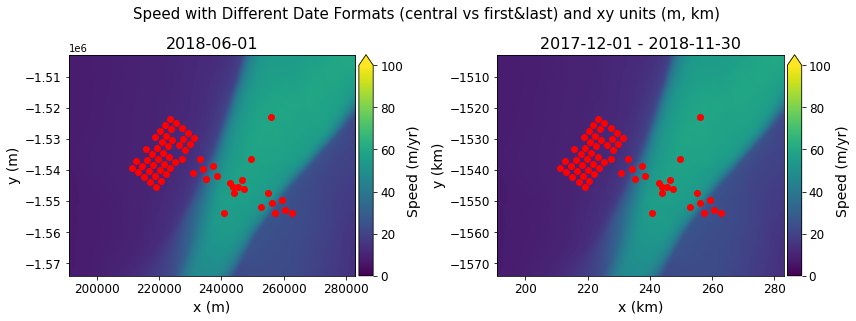

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4.5))
scale = {'m': 1., 'km': 0.001}
for ax, units, midDate in zip(axes, ['m', 'km'], [True, False]):
    myVel.displayVel(ax=ax, units=units, midDate=midDate)
    ax.plot(xGPS * scale[units], yGPS * scale[units], 'ro')
fig.suptitle('Speed with Different Date Formats (central vs first&last) and xy units (m, km) ', fontsize=15)
fig.tight_layout()

At this point, the lazy open still applies. In making the above plot, the data were loaded for the plot automatically by Dask. Depending on cache sizes, the data could be flushed and have to be re-downloaded before the next operation. If the data can comfortably fit in memory, it can be better to download them. As noted above, in addition to the Xarray, the data are broken out as individual numpy arrays (eg., `mYVel.vx, myVel.vy`. At this point, however, they are Dask arrays, meaning they haven't actually been executed (except on demand as in the above example).

In [12]:
myVel.subSetVel(xyBounds) # reset subset to avoid problem with out of order execution
print(type(myVel.vx))
print(f'vx[100, 100] type: {type(myVel.vx)}')

<class 'dask.array.core.Array'>
vx[100, 100] type: <class 'dask.array.core.Array'>


Instead of the velocity, we get the dask array, which contains instructions on how to retrieve the data when needed. In this case, we can get the value by cause Dask to compute by:

In [13]:
print(myVel.vx[100,100].compute())

[########################################] | 100% Completed | 406.45 ms
5.574975


If we force the data into memory, the component variables become regular numpy arrays and the subset becomes a regular xarray.

In [14]:
myVel.loadRemote()
print(f'vx[100, 100] type: {type(myVel.vx)}')
myVel.vx[100,100]

[########################################] | 100% Completed | 1.52 ss
vx[100, 100] type: <class 'numpy.ndarray'>


5.574975

In this example, with a fast internet connection there maybe no real advantage to downloading the data. But for larger data sets that take 10s of seconds to minutes to download, it can speed things up dramatically. It also allows the user to avoid complexities of dask (for example if they just want the value at a point). For many operations, however, the dask operations are transparent to the user (for example in plotting the data as shown above). 

## Interpolation

The velocity data can be interpolated as:

In [15]:
vxInterp, vyInterp, vvInterp = myVel.interp(xGPS, yGPS, units='m')

If we wanted to avoid the converstion from lat/lon to x, y coordinates above, we could simply passed the EPSG code for the coordinates as:

In [16]:
vxInterp1, vyInterp1, vvInterp1 = myVel.interp(latGPS, lonGPS, sourceEPSG=4326)

And to have the result returned as an Xarray instead of numpy, the call would be : 

In [17]:
velInterp = myVel.interp(latGPS, lonGPS, sourceEPSG=4326, returnXR=True)

As expected, the results are all identical.

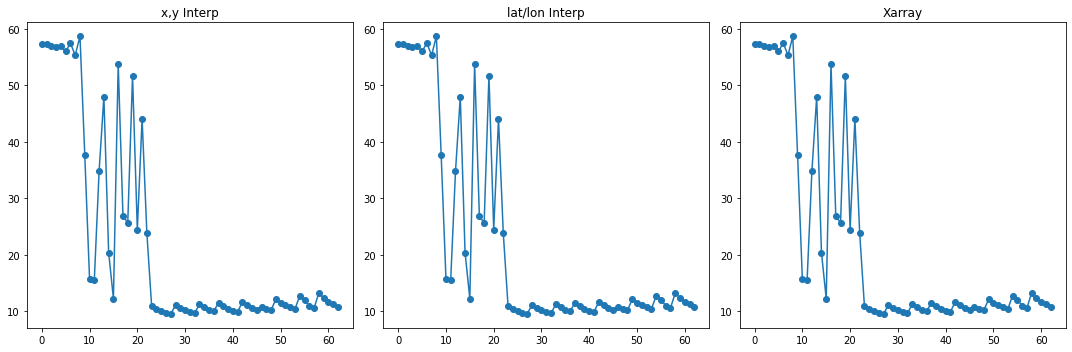

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, speed, title in zip(axes, [vvInterp, vvInterp1, np.squeeze(velInterp.sel(band='vv'))],
                       ['x,y Interp', 'lat/lon Interp', 'Xarray']):
    ax.plot(speed, '-o')
    ax.set_title(title)
fig.tight_layout()

## Velocity Series

In the above examples, only a single velocity product was used. Using `nisarVelSeries` class in place of the `nisarVel` several products can be read, subsetted, and downloaded. From this cell to the end of the notebook, the results are the same irrective of whether `loadRemote` is called. With `loadRemote`, however, the steps run about twice as fast using a local copy of the date. A `nisarVelSeries` can be instantiated and loaded with the following steps, which also include subsetting and data loading. 

In [19]:
start = datetime.now()
myVelSeries = nisar.nisarVelSeries()
if remote:  
    myVelSeries.readSeriesFromTiff(myCogs, url=True, readSpeed=False)
else:
    myFiles = [f'{dataDir}/{x}' for x in baseNames]
    myVelSeries.readSeriesFromTiff(myFiles, url=False, readSpeed=False)
#
myVelSeries.subSetVel(xyBounds) # Apply subset
#
myVelSeries.loadRemote()

[########################################] | 100% Completed | 3.85 sms


The velocity series work the same way as the single velocity products, except in some cases a date needs to be specified to select a layer and the method `displayVelForDate` is used. For example to plot the 2018 map the procedure would be.

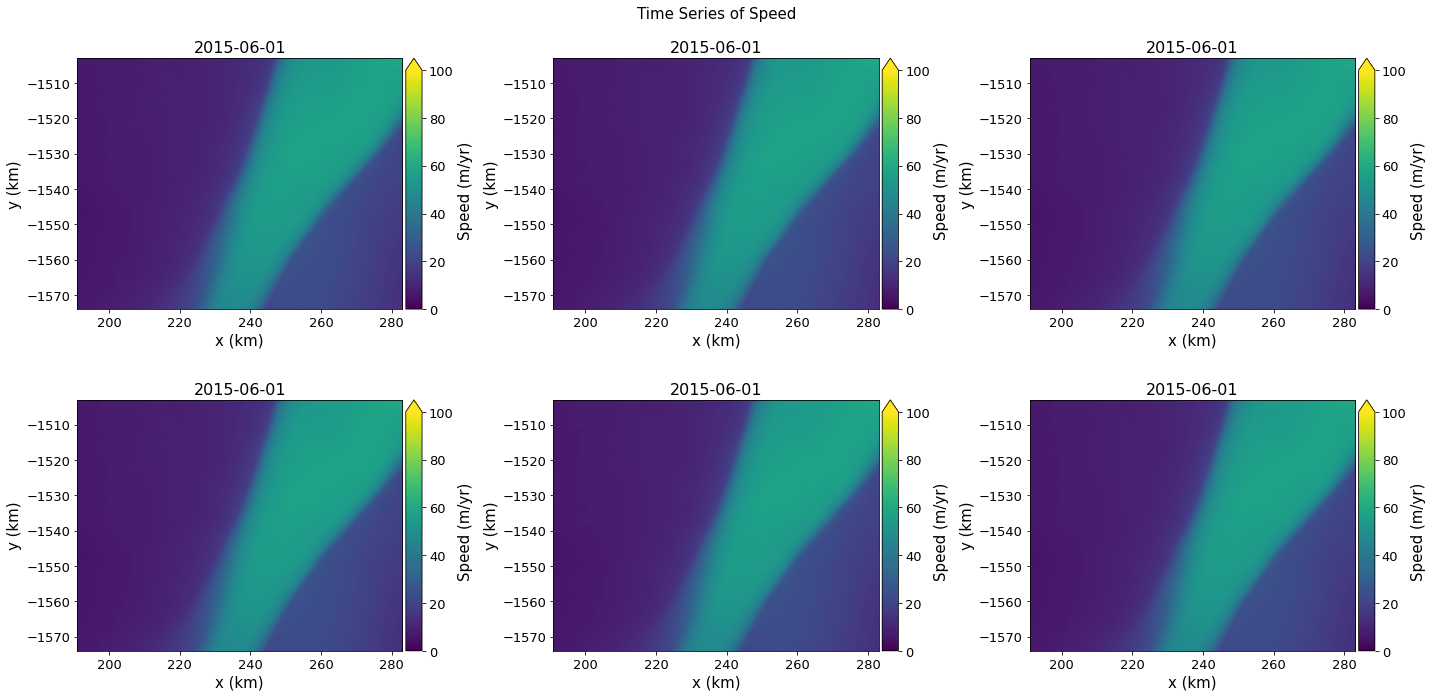

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for date, ax in zip(myVelSeries.time, axes.flatten()):
    myVelSeries.displayVelForDate(data=date, band='vv', ax=ax, units='km')
fig.suptitle('Time Series of Speed', fontsize=15)
fig.tight_layout()

## Operations on Velocity Series

Various operations can be applied in time and space to the velocity series. For example, at each point, the mean and standard devation along with the number of valid points for velocity time series are computed as:

In [21]:
%%time
#Compute Stats
velMean = myVelSeries.mean()
velSigma = myVelSeries.stdev()
velCount = myVelSeries.numberValid()

CPU times: user 54.4 ms, sys: 17.4 ms, total: 71.7 ms
Wall time: 70.4 ms


In the following example, the mean, standard deviation, and number of valid for each location are calculated. Note for the annual data in this fairly benign region, all points are valide (n=6). Each result is returned as a velocity series with only 1 time. The results can be plotted by:

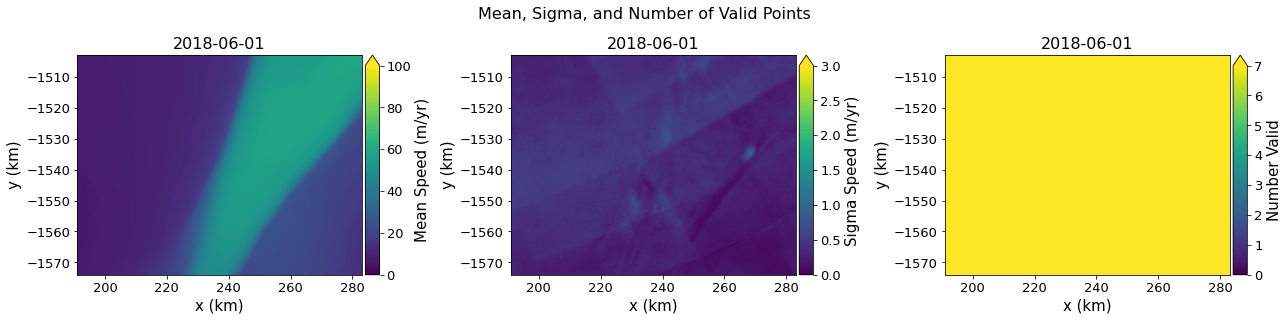

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18,4.5))
velMean.displayVelForDate(ax=axes[0], units=units, midDate=True, colorBarLabel='Mean Speed (m/yr)')
velSigma.displayVelForDate(ax=axes[1], date=None, units=units, midDate=True, vmin=0, vmax=3, autoScale=False, colorBarLabel='Sigma Speed (m/yr)')
velCount.displayVelForDate(ax=axes[2], date=None, units=units, midDate=True, vmin=0, vmax=7, autoScale=False, colorBarLabel='Number Valid')
fig.suptitle('Mean, Sigma, and Number of Valid Points', fontsize=16)
fig.tight_layout()

The anomalies (annual value - mean) can be calcuated for each time slices in the series as:

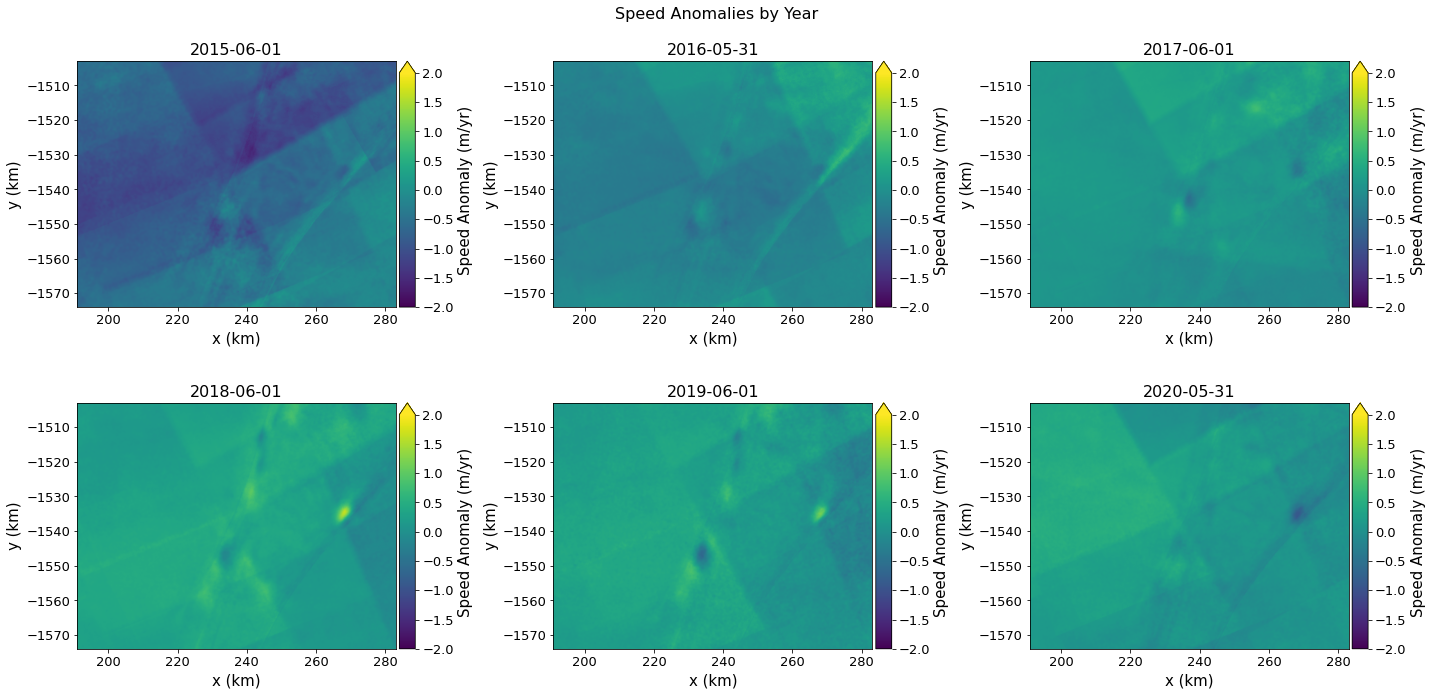

In [23]:
velAnomaly = myVelSeries.anomaly()
# Plot the anomaly for each year
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for date, ax in zip(velAnomaly.time, axes.flatten()):
    velAnomaly.displayVelForDate(date, ax=ax, units='km', vmin=-2, vmax=2, autoScale=False, colorBarLabel='Speed Anomaly (m/yr)')
fig.suptitle('Speed Anomalies by Year', fontsize=16)
fig.tight_layout()

The spatial mean for each time in the series can be computed as: 

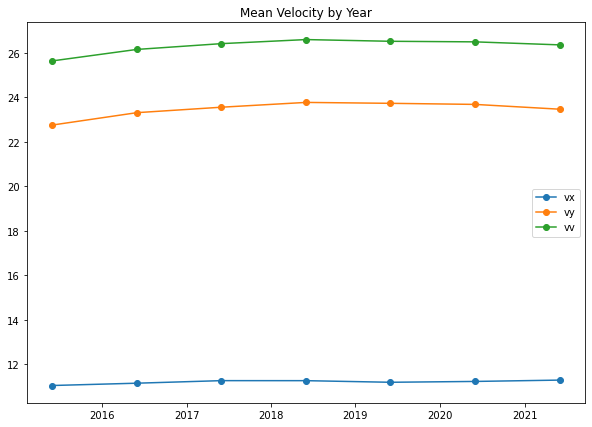

In [24]:
meanXR = myVelSeries.meanXY(returnXR=True) # returnXR=False will return x, y, speed means as nparrays
#
fig, ax = plt.subplots(1, 1, figsize=(10,7))
for band in meanXR.band:
    ax.plot(meanXR.time, meanXR.sel(band=band), '-o', label=band.item())
    ax.set_title('Mean Velocity by Year')
ax.legend();

The standard deviation for the anomalies computed above is evaluated and plotted by year using: 

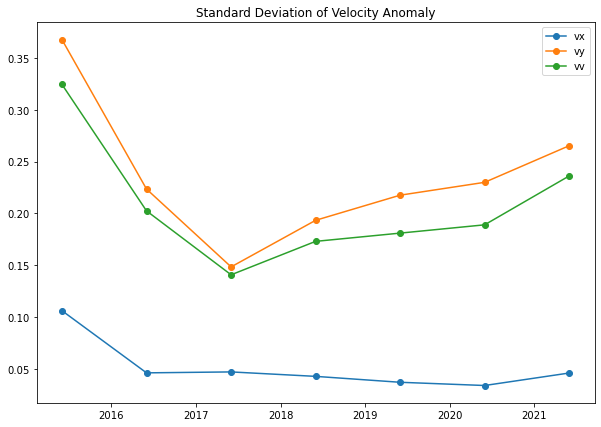

In [25]:
stdevAnomaly = velAnomaly.stdevXY(returnXR=True) # returnXR=False will return x, y, speed means as nparrays
#
fig, ax = plt.subplots(1, 1, figsize=(10,7))
for band in stdevAnomaly.band:
    ax.plot(stdevAnomaly.time, stdevAnomaly.sel(band=band), '-o', label=band.item())
    ax.set_title('Standard Deviation of Velocity Anomaly')
ax.legend();

This plot shows a) the precsion of the data and b) any true velocity change.

# Interpolation

In the examples above, the interpolation was for a single time.

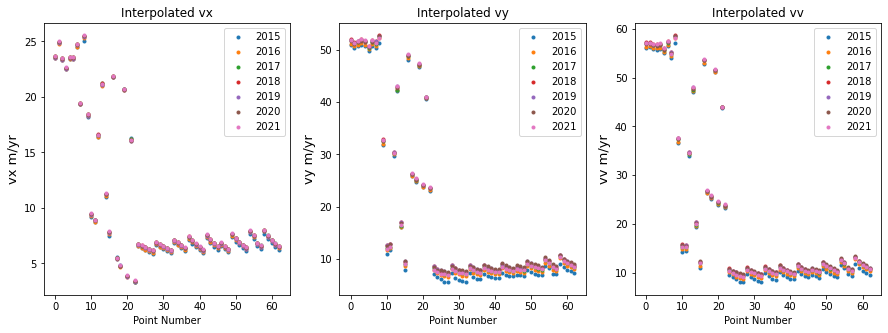

In [26]:
vxm, vym, vvm = myVelSeries.interp(xGPS, yGPS, date=None, units='m')  # All values.xyAll(), units='m')  # x,y coordinates are passed in as m
#
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, band, vInterp in zip(axes, ['vx', 'vy', 'vv'], [vxm, vym, vvm]):
    for date, v in zip(myVelSeries.time, vInterp):
        ax.plot(v, '.', label=date.strftime('%Y'))
    ax.legend()
    ax.set_title(f'Interpolated {band}')
    ax.set_xlabel('Point Number')
    ax.set_ylabel(f'{band} m/yr', fontsize=13)

The results can also be interpolated for each time. In this example, the result is return as an xarray:

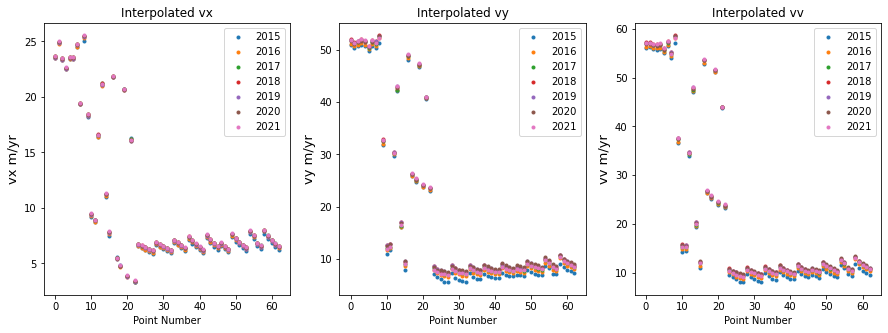

In [27]:
vPts = myVelSeries.interp(latGPS, lonGPS, date=None, units='m', returnXR=True, sourceEPSG=4326)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, band in zip(axes, vPts.band):
    for t in vPts.time:
        year = str(np.datetime64(t.item(0), 'ns'))[0:4]
        ax.plot(vPts.sel(band=band, time=t), '.', label=year)
    ax.legend()
    ax.set_title(f'Interpolated {band.data}')
    ax.set_xlabel('Point Number')
    ax.set_ylabel(f'{band.data} m/yr', fontsize=13)

## Multiple Subsets

When the data are loaded into a series, the details of the full map are stored even when the data are subsetted. As a result, its always possible to create a new subset without creating a new series (the prior subset will be lost) as shown by this example.

[########################################] | 100% Completed | 6.90 ss


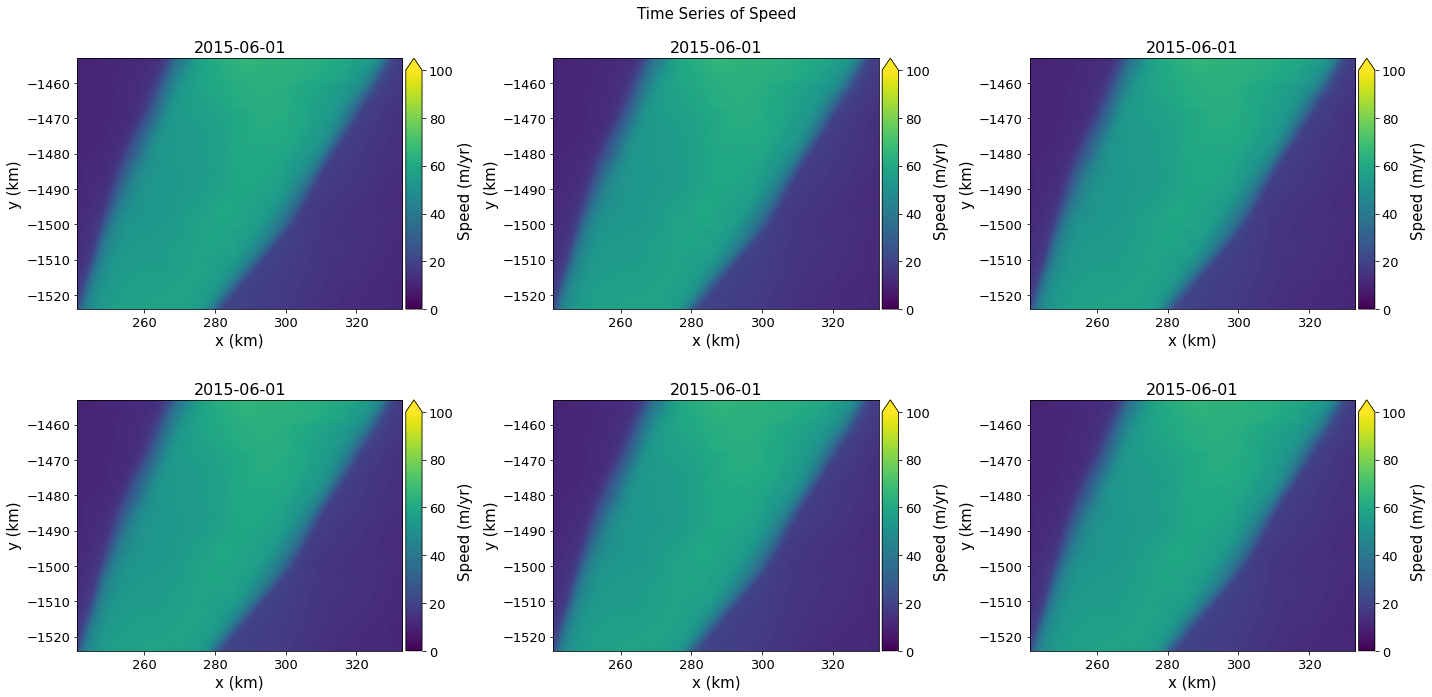

In [28]:
# Shift box by 50km
newBounds = {}
for key in xyBounds:
    newBounds[key] = xyBounds[key] + 50e3
#
myVelSeries.subSetVel(newBounds) # Apply subset
myVelSeries.loadRemote()
#
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for date, ax in zip(myVelSeries.time, axes.flatten()):
    myVelSeries.displayVelForDate(data=date, band='vv', ax=ax, units='km')
fig.suptitle('Time Series of Speed', fontsize=15)
fig.tight_layout()

## Saving the Data

The downloaded subset can be saved in a netcdf and reloaded for to `velSeries` instance for later analysis. Note if the data have been subsetted, **ONLY** the subset will be saved (~11MB in this example). If not, the entire Greeland data set will be saved (370GB).

In [29]:
myVelSeries.subSetVel(xyBounds) # Apply the original subset
myVelSeries.toNetCDF('xyBounds.nc')
myVelReload = nisar.nisarVelSeries()
myVelReload.readSeriesFromNetCDF('xyBounds.nc')
myVelReload.loadRemote()
os.remove('xyBounds.nc')  # Cleanup and remove file, comment out this line to keep file

[########################################] | 100% Completed | 3.76 sms


The next cell reloads and plots the data.

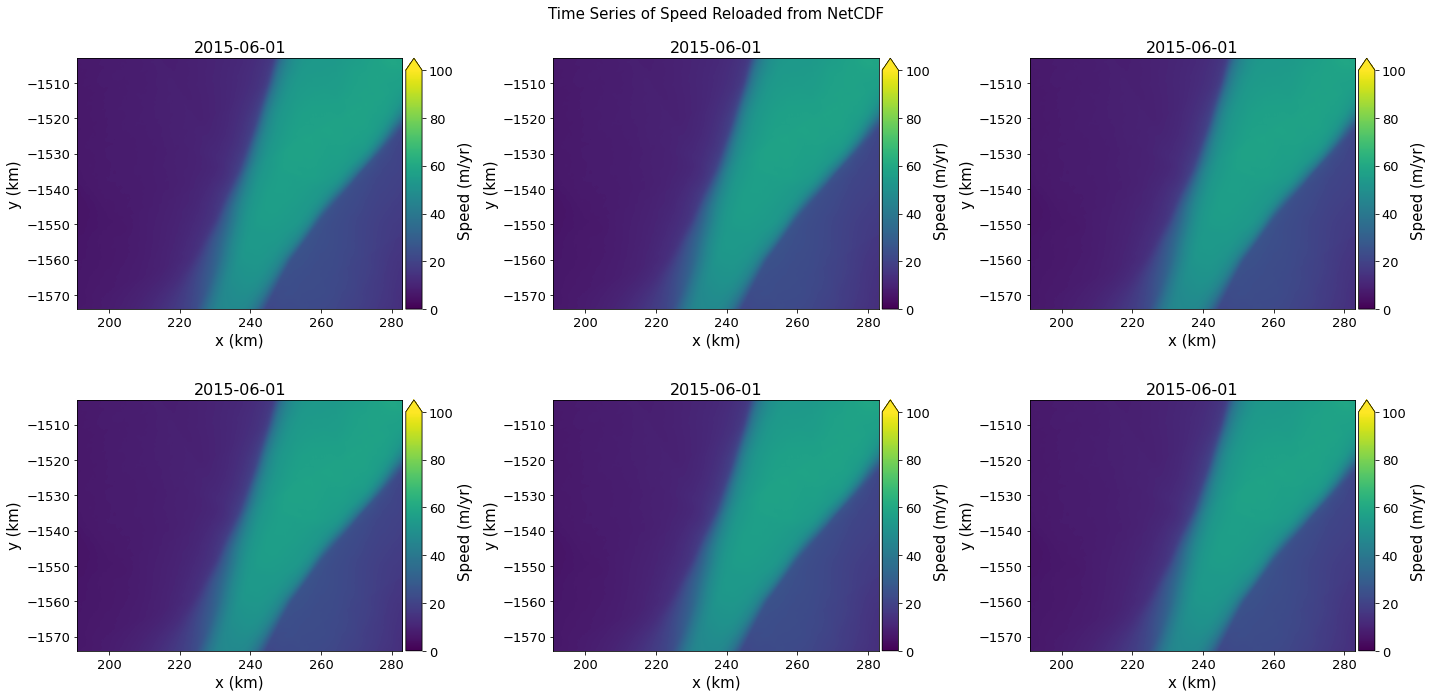

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for date, ax in zip(myVelReload.time, axes.flatten()):
    myVelReload.displayVelForDate(data=date, band='vv', ax=ax, units='km')
fig.suptitle('Time Series of Speed Reloaded from NetCDF', fontsize=15)
fig.tight_layout()

In [31]:
myVel.toNetCDF('test1.nc')
myVel.readDataFromNetCDF('test1.nc')
#myVel.xr

The next cell plots the reloaded velocity map and also demonstrates the log color table.

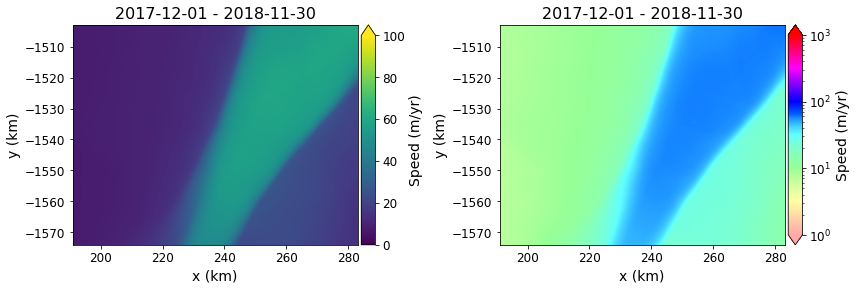

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12,4.5))
myVel.displayVel(ax=axes[0], units=units, midDate=midDate)
myVel.displayVel(ax=axes[1], units=units, midDate=midDate, vmin=1, vmax=1000, scale='log', percentile=99)
fig.tight_layout()